**O objetivo deste desafio de Data Science é utilizar os dados disponíveis 
para medir a probabilidade de sobrevivência dos passageiros do Titanic.**

In [1]:
# Bibliotecas para carregar/manipular os dados
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
import re as re

# Biblioteca para ML
from sklearn import ensemble

from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# Carrega a base de dados de treino e teste
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

**-- INÍCIO DA ANÁLISE EXPLORATÓRIA --**

In [5]:
# verificando as dimensões dos Datasets
print("Variáveis:\t{}\nEntradas:\t{}".format(train.shape[1], train.shape[0]))
print("Variáveis:\t{}\nEntradas:\t{}".format(test.shape[1], test.shape[0]))

Variáveis:	12
Entradas:	891
Variáveis:	11
Entradas:	418


In [6]:
# Identificar o tipo de dado e os 5 primeiros exemples do dataset
display(train.dtypes)
display(train.head())

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# Percentual de missing value
(train.isnull().sum() / train.shape[0]).sort_values(ascending=False)*100
#(test.isnull().sum() / test.shape[0]).sort_values(ascending=False)*100

Cabin          77.104377
Age            19.865320
Embarked        0.224467
Fare            0.000000
Ticket          0.000000
Parch           0.000000
SibSp           0.000000
Sex             0.000000
Name            0.000000
Pclass          0.000000
Survived        0.000000
PassengerId     0.000000
dtype: float64

In [8]:
# Visão gerão da distribuição de cada variável
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


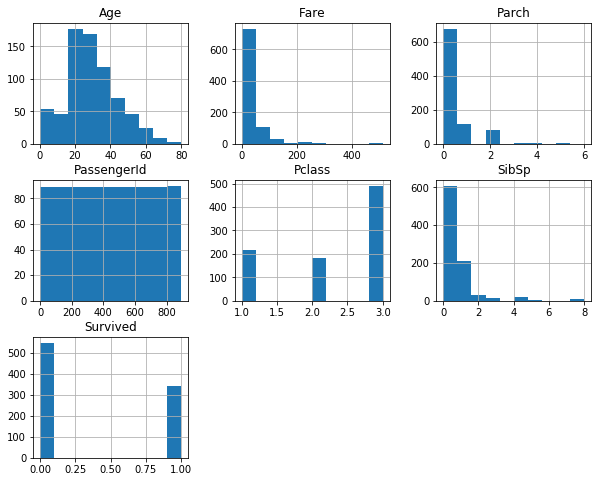

In [9]:
# Ver histograma das variáveis numéricas
train.hist(figsize=(10,8));

In [10]:
# Analisar a probabilidade de sobrevivência pelo Sexo
train[['Sex', 'Survived']].groupby(['Sex']).mean()

,Survived
Sex,
female,0.742038
male,0.188908


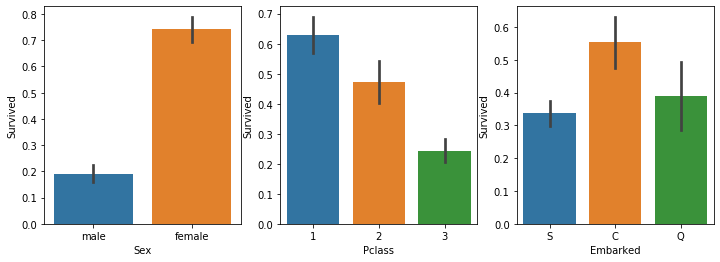

In [11]:
# Plotar os gráficos de barra para Survived vs. Sex, Pclass e Embarked
fig, (axis1, axis2, axis3) = plt.subplots(1,3, figsize=(12,4))

sns.barplot(x='Sex', y='Survived', data=train, ax=axis1)
sns.barplot(x='Pclass', y='Survived', data=train, ax=axis2)
sns.barplot(x='Embarked', y='Survived', data=train, ax=axis3);

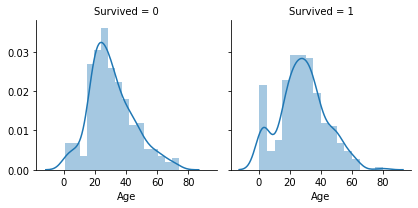

In [12]:
# Influência da idade na probabilidade de sobrevivência. 
# É possível identificar um índice alto de sobrevivência entre crianças
age_survived = sns.FacetGrid(train, col='Survived')
age_survived.map(sns.distplot, 'Age');

**-- JUNTAR DATASET TREINO E TESTE E TRATAR MISSING VALUES --**

In [13]:
# Juntar os datasets de treino e teste
# salvar os índices dos datasets para recuperação posterior
train_idx = train.shape[0]
test_idx = test.shape[0]

# salvar PassengerId para submissao ao Kaggle
passengerId = test['PassengerId']

# extrair coluna 'Survived' e excluí-la do dataset treino
label = train.Survived.copy()
train.drop(['Survived'], axis=1, inplace=True)

# concatenar treino e teste em um único DataFrame
df_merged = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

# antes
print("train.shape: ({} x {})".format(train.shape[0], train.shape[1]))
print("test.shape: ({} x {})".format(test.shape[0], test.shape[1]))

# e depois da concatenação
print("df_merged.shape: ({} x {})".format(df_merged.shape[0], df_merged.shape[1]))

train.shape: (891 x 11)
test.shape: (418 x 11)
df_merged.shape: (1309 x 11)


In [14]:
# Desconsiderar features a princípio não relevantes
df_merged.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)
#print("df_merged.shape: ({} x {})".format(df_merged.shape[0], df_merged.shape[1]))

In [15]:
# Ver missing values
df_merged.isnull().sum()

Pclass        0
Name          0
Sex           0
Age         263
SibSp         0
Parch         0
Fare          1
Embarked      2
dtype: int64

In [16]:
# recuperar os titulos dos nomes dos passageiros
def extrai_titulo(df):
    df['Titulo'] = df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip().lower())
    
extrai_titulo(df_merged)
df_merged.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Titulo
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,mr


In [17]:
# Agora podemos retirar a coluna Name
df_merged.drop(['Name'], axis=1, inplace=True)
df_merged.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titulo
0,3,male,22.0,1,0,7.2500,S,mr
1,1,female,38.0,1,0,71.2833,C,mrs
2,3,female,26.0,0,0,7.9250,S,miss
3,1,female,35.0,1,0,53.1000,S,mrs
4,3,male,35.0,0,0,8.0500,S,mr


Text(0.5, 0, 'Quantidade por titulo')

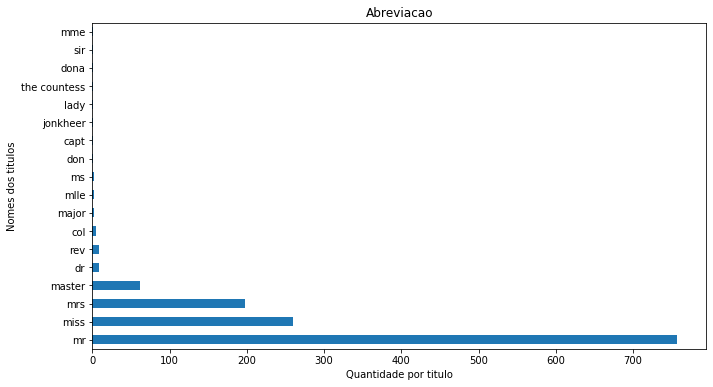

In [18]:
# verificando a distribuição dos titulos
fig = plt.figure(figsize=(11,6))
fig = df_merged['Titulo'].value_counts().plot.barh()
fig.set_title('Abreviacao')
fig.set_ylabel('Nomes dos titulos')
fig.set_xlabel('Quantidade por titulo')

In [19]:
# age - mediana
age_median = df_merged['Age'].median()
df_merged['Age'].fillna(age_median, inplace=True)

# fare - mediana
fare_median = df_merged['Fare'].median()
df_merged['Fare'].fillna(fare_median, inplace=True)

# embarked - moda
embarked_top = df_merged['Embarked'].value_counts()[0]
df_merged['Embarked'].fillna(embarked_top, inplace=True)

# Ver missing values após tratamento
df_merged.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Titulo      0
dtype: int64

**-- PREPARAR AS VARIÁVEIS CATEGÓRICAS PARA O MODELO --**

In [20]:
# transformar os dados de entrada que estão em formato categoria para números
# converter 'Sex' em 0 e 1
df_merged['Sex'] = df_merged['Sex'].map({'male': 0, 'female': 1})

# dummie variables para 'Embarked'
embarked_dummies = pd.get_dummies(df_merged['Embarked'], prefix='Embarked')
df_merged = pd.concat([df_merged, embarked_dummies], axis=1)
df_merged.drop('Embarked', axis=1, inplace=True)
df_merged.drop(['Embarked_914'], axis=1, inplace=True)

# tratamento dos titulos raros
def titulo_raro(passageiro):
    linha = passageiro
    if re.search('mrs', linha):
        return 'mrs'
    elif re.search('mr', linha):
        return 'mr'
    elif re.search('miss',linha):
        return 'miss'
    elif re.search('master',linha):
        return 'master'
    else:
        return 'other'
    
# dummies para titulo
embarked_titulo = pd.get_dummies(df_merged['Titulo'].apply(titulo_raro), prefix='Titulo')
df_merged = pd.concat([df_merged, embarked_titulo], axis=1)
df_merged.drop('Titulo', axis=1, inplace=True)

df_merged.sample(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Titulo_master,Titulo_miss,Titulo_mr,Titulo_mrs,Titulo_other
309,1,1,30.0,0,0,56.9292,1,0,0,0,1,0,0,0
931,3,0,39.0,0,1,13.4167,1,0,0,0,0,1,0,0
59,3,0,11.0,5,2,46.9000,0,0,1,1,0,0,0,0
369,1,1,24.0,0,0,69.3000,1,0,0,0,0,0,0,1
1089,2,0,23.0,0,0,10.5000,0,0,1,0,0,1,0,0


**-- DIVIDIR O DATASET CONCATENADO E TRATADO EM TREINO E TESTE --**

In [21]:
# recuperar datasets de treino e teste
train = df_merged.iloc[:train_idx]
test = df_merged.iloc[train_idx:]

display(train.head())
display(test.head())
display(label.head())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Titulo_master,Titulo_miss,Titulo_mr,Titulo_mrs,Titulo_other
0,3,0,22.0,1,0,7.2500,0,0,1,0,0,1,0,0
1,1,1,38.0,1,0,71.2833,1,0,0,0,0,0,1,0
2,3,1,26.0,0,0,7.9250,0,0,1,0,1,0,0,0
3,1,1,35.0,1,0,53.1000,0,0,1,0,0,0,1,0
4,3,0,35.0,0,0,8.0500,0,0,1,0,0,1,0,0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Titulo_master,Titulo_miss,Titulo_mr,Titulo_mrs,Titulo_other
891,3,0,34.5,0,0,7.8292,0,1,0,0,0,1,0,0
892,3,1,47.0,1,0,7.0000,0,0,1,0,0,0,1,0
893,2,0,62.0,0,0,9.6875,0,1,0,0,0,1,0,0
894,3,0,27.0,0,0,8.6625,0,0,1,0,0,1,0,0
895,3,1,22.0,1,1,12.2875,0,0,1,0,0,0,1,0


0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

**-- IMPLEMENTAR O MODELO --**

In [22]:
# criar um modelo de árvore de decisão
model = ensemble.GradientBoostingClassifier(n_estimators=500,
                                    validation_fraction=0.2,
                                    n_iter_no_change=5, tol=0.01,
                                    random_state=0)
model.fit(train, label)

# verificar a acurácia do modelo
acc_model = round(model.score(train, label) * 100, 2)
print("Acurácia do modelo de Árvore de Decisão: {}".format(acc_model))

Acurácia do modelo de Árvore de Decisão: 85.19


**-- GERAR ARQUIVO PARA SUBMISSÃO --**

In [23]:
predict = model.predict(test)

In [24]:
# gerar arquivo csv
submission = pd.DataFrame({
    "PassengerId": passengerId,
    "Survived": predict
})

submission.to_csv('./my_submission.csv', index=False)
print("Arquivo gerado com sucesso")
submission

Arquivo gerado com sucesso


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
